#Importing

In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import datetime
import numpy as np
import tensorflow as tf
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Dropout,TimeDistributed,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.optimizers import Adam
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

#Getting data via yfinance API

In [2]:
stock=yf.Ticker("RELIANCE.NS")
df=stock.history(period='1d',start=datetime.date.today()-relativedelta(years=5),end=datetime.date.today())

In [3]:
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2018-06-20 00:00:00+05:30,965.529586,991.606631,964.414749,988.068298,7262014,0.0,0.0
2018-06-21 00:00:00+05:30,992.139759,1004.305852,990.055583,1000.379761,10609377,0.0,0.0
2018-06-22 00:00:00+05:30,996.938449,997.713968,977.598749,981.524841,16323253,0.0,0.0
2018-06-25 00:00:00+05:30,980.458415,985.402404,971.636834,973.721069,5246962,0.0,0.0
2018-06-26 00:00:00+05:30,975.223583,975.223583,945.414328,949.001160,8145067,0.0,0.0
...,...,...,...,...,...,...,...
2023-06-13 00:00:00+05:30,2495.000000,2523.449951,2486.250000,2520.850098,5190958,0.0,0.0
2023-06-14 00:00:00+05:30,2521.000000,2555.000000,2517.000000,2551.850098,6127509,0.0,0.0
2023-06-15 00:00:00+05:30,2551.800049,2562.550049,2535.500000,2552.550049,5451926,0.0,0.0


In [4]:
df.describe

<bound method NDFrame.describe of                                   Open         High          Low        Close  \
Date                                                                            
2018-06-20 00:00:00+05:30   965.529586   991.606631   964.414749   988.068298   
2018-06-21 00:00:00+05:30   992.139759  1004.305852   990.055583  1000.379761   
2018-06-22 00:00:00+05:30   996.938449   997.713968   977.598749   981.524841   
2018-06-25 00:00:00+05:30   980.458415   985.402404   971.636834   973.721069   
2018-06-26 00:00:00+05:30   975.223583   975.223583   945.414328   949.001160   
...                                ...          ...          ...          ...   
2023-06-13 00:00:00+05:30  2495.000000  2523.449951  2486.250000  2520.850098   
2023-06-14 00:00:00+05:30  2521.000000  2555.000000  2517.000000  2551.850098   
2023-06-15 00:00:00+05:30  2551.800049  2562.550049  2535.500000  2552.550049   
2023-06-16 00:00:00+05:30  2560.199951  2582.399902  2560.199951  2577.3999

#Visualizations

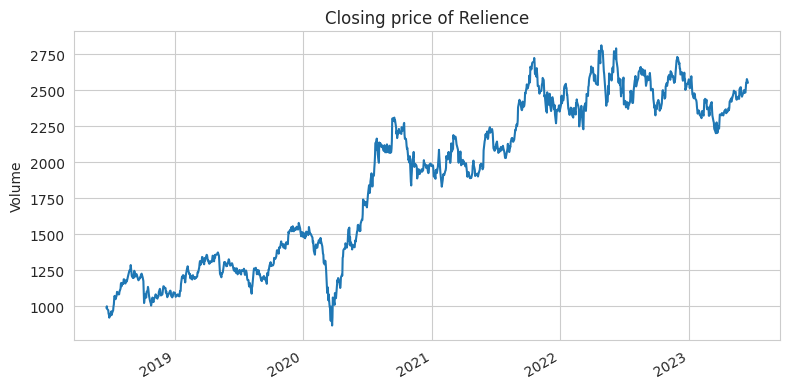

In [5]:
plt.figure(figsize=(8, 4))

df['Close'].plot()
plt.ylabel('Volume')
plt.xlabel(None)
plt.title('Closing price of Relience')

plt.tight_layout()

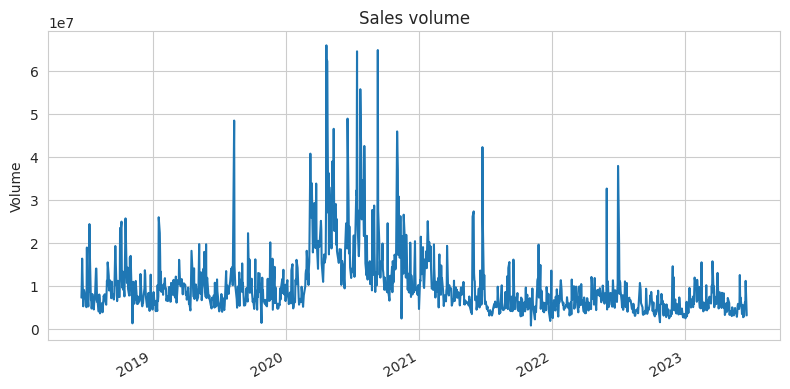

In [6]:
plt.figure(figsize=(8, 4))

df['Volume'].plot()
plt.ylabel('Volume')
plt.xlabel(None)
plt.title('Sales volume')

plt.tight_layout()

#Scaling and spliting datas

In [7]:
df_minmax=df.iloc[:,3:4]
scaler=MinMaxScaler(feature_range=(0,1))
df_minmax=scaler.fit_transform(df_minmax)

In [8]:
df_minmax

array([[0.06223443],
       [0.06856644],
       [0.05886901],
       ...,
       [0.86687606],
       [0.8796568 ],
       [0.86649032]])

In [9]:
training_size=int(len(df_minmax)*0.65)
test_size=len(df_minmax)-training_size
train_data,test_data=df_minmax[0:training_size,:],df_minmax[training_size:len(df_minmax)]

In [10]:
def makeFeature(data,feature=24):
  x=list()
  y=list()
  for i in range(len(data)-feature-1):
    x.append(data[i:(i+feature),0])
    y.append(data[i+feature,0])
  x=np.array(x)
  y=np.array(y)
  return x,y

In [11]:
x_train,y_train=makeFeature(train_data)
x_test,y_test=makeFeature(test_data)


In [12]:
x_train.shape

(777, 24)

In [13]:
x_train=np.reshape(x_train,(x_train.shape[0],1,24,1))
x_test=np.reshape(x_test,(x_test.shape[0],1,24,1))



In [14]:
x_train.shape

(777, 1, 24, 1)

In [15]:
x_test.shape

(407, 1, 24, 1)

#Making Model

In [21]:
from tensorflow.keras.layers import Conv1D,MaxPooling1D
model = Sequential([
    TimeDistributed(Conv1D(filters = 6,kernel_size = 3, activation = 'relu'),input_shape=(None, 24, 1)),
    TimeDistributed(MaxPooling1D()),
    TimeDistributed(Flatten()),
    LSTM(100,return_sequences=False,input_shape=(x_train.shape[1],1)),
    Dropout(0.42),
#     LSTM(50,return_sequences=False),
#     Dropout(0.3),
    Dense(1)
])
model.compile(optimizer='adam',loss='mean_squared_error',metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_9 (TimeDis  (None, None, 22, 6)      24        
 tributed)                                                       
                                                                 
 time_distributed_10 (TimeDi  (None, None, 11, 6)      0         
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, None, 66)         0         
 stributed)                                                      
                                                                 
 lstm_3 (LSTM)               (None, 100)               66800     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                      

In [23]:
cb=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=20,mode='max')
stock_price=model.fit(x_train,y_train,epochs=100,batch_size=24,validation_data=(x_test,y_test),callbacks=cb)

Epoch 1/100
33/33 [==============================] - 14s 25ms/step - loss: 0.0468 - accuracy: 0.0013 - val_loss: 0.0029 - val_accuracy: 0.0025
Epoch 2/100
33/33 [==============================] - 0s 6ms/step - loss: 0.0062 - accuracy: 0.0013 - val_loss: 0.0027 - val_accuracy: 0.0025
Epoch 3/100
33/33 [==============================] - 0s 7ms/step - loss: 0.0043 - accuracy: 0.0013 - val_loss: 0.0033 - val_accuracy: 0.0025
Epoch 4/100
33/33 [==============================] - 0s 7ms/step - loss: 0.0046 - accuracy: 0.0013 - val_loss: 0.0025 - val_accuracy: 0.0025
Epoch 5/100
33/33 [==============================] - 0s 7ms/step - loss: 0.0043 - accuracy: 0.0013 - val_loss: 0.0024 - val_accuracy: 0.0025
Epoch 6/100
33/33 [==============================] - 0s 7ms/step - loss: 0.0037 - accuracy: 0.0013 - val_loss: 0.0024 - val_accuracy: 0.0025
Epoch 7/100
33/33 [==============================] - 0s 8ms/step - loss: 0.0035 - accuracy: 0.0013 - val_loss: 0.0023 - val_accuracy: 0.0025
Epoch 8/100

#Predicting

In [24]:
train_predict=model.predict(x_train)
test_predict=model.predict(x_test)

13/13 [==============================] - 0s 2ms/step


In [25]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)


In [27]:
train_predict.shape

(777, 1)

In [28]:
test_predict.shape

(407, 1)

#Plotting

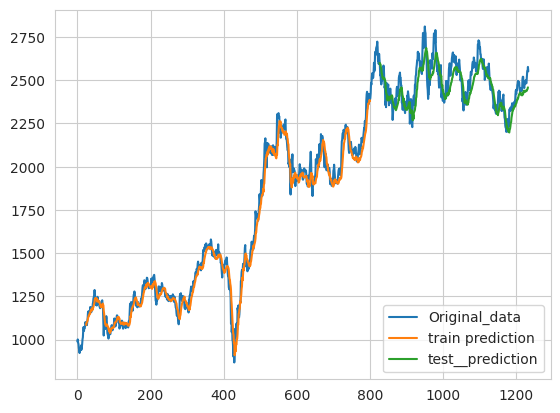

In [31]:
look_back=24
trainPredictPlot = np.empty_like(df_minmax)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df_minmax)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df_minmax)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df_minmax))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.legend(['Original_data', 'train prediction', 'test__prediction'], loc='lower right')
plt.show()